## Overview 
The goal of this script is to use a simple neural network to use the depth camera readings to estimimate $\theta_z$. For now, the input data will just be the vectorized depth frames and the output data will be $\theta_z$.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal
import pickle
from sklearn.preprocessing import StandardScaler
import random
import tensorflow as tf
import cv2

# change directory 
n_test = 13
date = '11_11_2020'
test_str = r'\test' + str(n_test)
data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str




## Read Input Data (Depth Camera Data)

In [82]:
# For reading depth camera
def read_depth_camera(dcamera_path, show_video):
    video  = cv2.VideoCapture(dcamera_path)
    ret, frame = video.read()
    
    # Get total # of frame count 
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        
    frame_height = int(frame.shape[0]/5)
    frame_width = int(frame.shape[1]/5)

    
    depth_frames = np.empty((frame_count, frame_height, frame_width))
    
    count = 0
    while (video.isOpened()):
        ret, frame = video.read()
        if ret == True:
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            gray_frame = cv2.resize(gray_frame, (frame_width, frame_height), interpolation = cv2.INTER_AREA)
            depth_frames[count] = gray_frame
            if show_video == True:
                cv2.imshow("Depth", gray_frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            count = count + 1
        else: 
            break
            

    video.release()
    cv2.destroyAllWindows()
    return depth_frames

In [154]:
n_test = 13
date = '11_11_2020'
test_str = r'\test' + str(n_test)
data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str

train_dcamera_path = data_dir + r'\depth_processed_leo_test'+str(n_test)+'.avi'
show_video = 0
x_train = read_depth_camera(train_dcamera_path, show_video) / 255.0

n_test = 14
date = '11_11_2020'
test_str = r'\test' + str(n_test)
data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str

train_dcamera_path = data_dir + r'\depth_processed_leo_test'+str(n_test)+'.avi'
show_video = 0
x_temp = read_depth_camera(train_dcamera_path, show_video) / 255.0
x_train = np.concatenate((x_train,x_temp))

n_test = 15
date = '11_11_2020'
test_str = r'\test' + str(n_test)
data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str

train_dcamera_path = data_dir + r'\depth_processed_leo_test'+str(n_test)+'.avi'
show_video = 0
x_temp = read_depth_camera(train_dcamera_path, show_video) / 255.0
x_train = np.concatenate((x_train,x_temp))


val_n_test = 16
val_date = '11_11_2020'
val_test_str = r'\test' + str(val_n_test)
val_data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + val_test_str

val_dcamera_path = val_data_dir + r'\depth_processed_leo_test'+str(val_n_test)+'.avi'
x_test = read_depth_camera(val_dcamera_path, show_video) / 255.0

## Read Output Data (Theta_z)

In [85]:
def read_output_data(qtm_file_data, theta):
    if theta=='x':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Left/Right Angle (deg)"])
    if theta=='y':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Forward/Backwards Angle (deg)"])
    if theta=='z':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Torso Twist Angle (deg)"])
        
    
    return qtm_data




In [153]:
n_test = 13
date = '11_11_2020'
test_str = r'\test' + str(n_test)
data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
qtm_file_data_dir = data_dir + r'\qtm_processed_leo_test' + str(n_test) + '_' + date + '.txt'
show_qtm_plot = True
theta_interest = 'z'
y_train = read_output_data(qtm_file_data_dir,theta_interest)

n_test = 14
date = '11_11_2020'
test_str = r'\test' + str(n_test)
data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
qtm_file_data_dir = data_dir + r'\qtm_processed_leo_test' + str(n_test) + '_' + date + '.txt'
y_train_temp = read_output_data(qtm_file_data_dir,theta_interest)
y_train = np.concatenate((y_train, y_train_temp))

n_test = 15
date = '11_11_2020'
test_str = r'\test' + str(n_test)
data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
qtm_file_data_dir = data_dir + r'\qtm_processed_leo_test' + str(n_test) + '_' + date + '.txt'
y_train_temp = read_output_data(qtm_file_data_dir,theta_interest)
y_train = np.concatenate((y_train, y_train_temp))


val_n_test = 16

val_qtm_file_data_dir = val_data_dir + r'\qtm_processed_leo_test' + str(val_n_test) + '_' + val_date + '.txt'
y_test = read_output_data(val_qtm_file_data_dir,theta_interest)

## Create Neural Network Model (v1)

In [66]:
 model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(120, 160)),
        tf.keras.layers.Dense(200, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1)
])
    
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# loss_fn(y_train[:1], predictions).numpy()

model.compile(optimizer='adam',
              loss='mae',
              metrics=['mae'])

model.fit(x_train, y_train, epochs= 100)


Epoch 1/100
146/146 [==============================] - 4s 28ms/step - loss: 15.4799 - mae: 15.2887
Epoch 2/100
146/146 [==============================] - 5s 33ms/step - loss: 14.7353 - mae: 14.5979
Epoch 3/100
146/146 [==============================] - 5s 33ms/step - loss: 14.5769 - mae: 14.4452
Epoch 4/100
146/146 [==============================] - 5s 33ms/step - loss: 14.4156 - mae: 14.2691
Epoch 5/100
146/146 [==============================] - 5s 33ms/step - loss: 14.1410 - mae: 13.9795
Epoch 6/100
146/146 [==============================] - 5s 33ms/step - loss: 14.2072 - mae: 14.0305
Epoch 7/100
146/146 [==============================] - 5s 33ms/step - loss: 13.8679 - mae: 13.6665
Epoch 8/100
146/146 [==============================] - 5s 33ms/step - loss: 13.8547 - mae: 13.6292
Epoch 9/100
146/146 [==============================] - 5s 33ms/step - loss: 13.6840 - mae: 13.4353
Epoch 10/100
146/146 [==============================] - 5s 33ms/step - loss: 13.6523 - mae: 13.3826
Epoch 11/

146/146 [==============================] - 5s 32ms/step - loss: 11.4076 - mae: 10.7344
Epoch 84/100
146/146 [==============================] - 5s 32ms/step - loss: 11.3403 - mae: 10.6676
Epoch 85/100
146/146 [==============================] - 5s 32ms/step - loss: 11.1486 - mae: 10.4748
Epoch 86/100
146/146 [==============================] - 5s 32ms/step - loss: 11.1475 - mae: 10.4716
Epoch 87/100
146/146 [==============================] - 5s 32ms/step - loss: 11.6484 - mae: 10.9676
Epoch 88/100
146/146 [==============================] - 5s 32ms/step - loss: 11.5379 - mae: 10.8512
Epoch 89/100
146/146 [==============================] - 5s 31ms/step - loss: 11.4019 - mae: 10.7150
Epoch 90/100
146/146 [==============================] - 4s 28ms/step - loss: 11.6261 - mae: 10.9397
Epoch 91/100
146/146 [==============================] - 4s 27ms/step - loss: 11.3417 - mae: 10.6569
Epoch 92/100
146/146 [==============================] - 4s 27ms/step - loss: 11.4658 - mae: 10.7788
Epoch 93/100


55/55 - 0s - loss: 16.2003 - mae: 15.5039


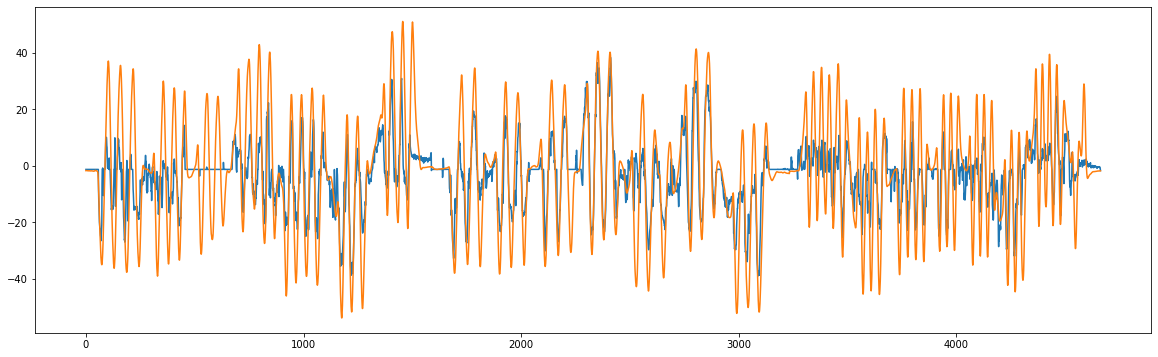

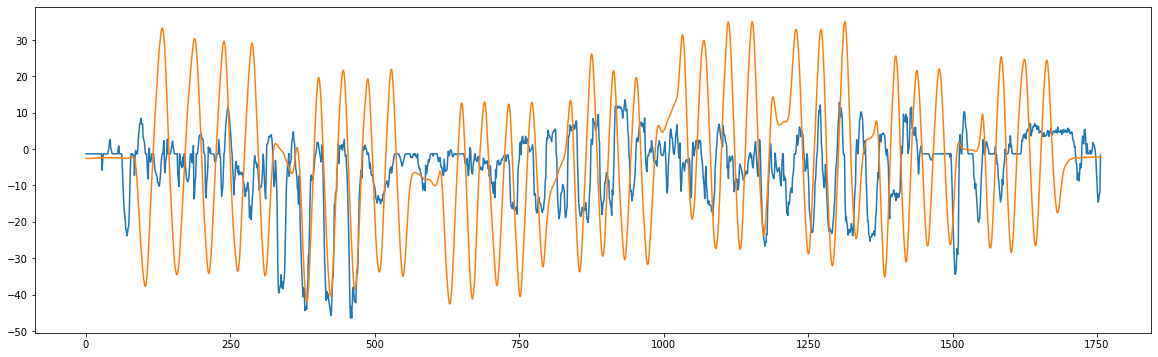

In [67]:
model.evaluate(x_test,  y_test, verbose=2)

y_pred_train = model.predict(x_train)
plt.figure(figsize = (20,6))
plt.plot(y_pred_train[:,-1])
plt.plot(y_train)

y_pred_test = model.predict(x_test)
plt.figure(figsize = (20,6))
plt.plot(y_pred_test[:,-1])
plt.plot(y_test)


### Notes on V1 
V1 approach is straightforward: dump all the depth data and run with simple plain vanilla neural network (i.e., multi-layer perceptron). 'MAE' Seems to work better than 'MSE'. Some problems that I have is overfitting. I tried using L1 regulator and dropouts,but it didn't work. Initially I only used one video file for training, but then I increased the training set data to 3 video files. Still didn't solve the overfitting problem. I'll try reducing the video frame size and run layers with more neurons just like the MNIST digit example they showed in tensor flow.  

## Create Neural Network (V2)

In [112]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(24, 32)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.Dense(1)
])
    
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# loss_fn(y_train[:1], predictions).numpy()

model.compile(optimizer='adam',
              loss='mae',
              metrics=['mae'])

history = model.fit(x_train, y_train, epochs= 300, validation_split = 0.2)


Epoch 1/300
117/117 [==============================] - 0s 2ms/step - loss: 15.4193 - mae: 15.3900 - val_loss: 14.0360 - val_mae: 14.0089
Epoch 2/300
117/117 [==============================] - 0s 1ms/step - loss: 15.1002 - mae: 15.0732 - val_loss: 13.8705 - val_mae: 13.8434
Epoch 3/300
117/117 [==============================] - 0s 1ms/step - loss: 14.8803 - mae: 14.8528 - val_loss: 13.9916 - val_mae: 13.9636
Epoch 4/300
117/117 [==============================] - 0s 1ms/step - loss: 14.7967 - mae: 14.7680 - val_loss: 13.8857 - val_mae: 13.8564
Epoch 5/300
117/117 [==============================] - 0s 1ms/step - loss: 14.6458 - mae: 14.6157 - val_loss: 14.0387 - val_mae: 14.0078
Epoch 6/300
117/117 [==============================] - 0s 1ms/step - loss: 14.5402 - mae: 14.5086 - val_loss: 14.1487 - val_mae: 14.1163
Epoch 7/300
117/117 [==============================] - 0s 1ms/step - loss: 14.4078 - mae: 14.3743 - val_loss: 13.8286 - val_mae: 13.7937
Epoch 8/300
117/117 [====================

117/117 [==============================] - 0s 1ms/step - loss: 12.5597 - mae: 12.4374 - val_loss: 13.3187 - val_mae: 13.1956
Epoch 61/300
117/117 [==============================] - 0s 1ms/step - loss: 12.4979 - mae: 12.3743 - val_loss: 13.5258 - val_mae: 13.4015
Epoch 62/300
117/117 [==============================] - 0s 1ms/step - loss: 12.4823 - mae: 12.3575 - val_loss: 13.3901 - val_mae: 13.2642
Epoch 63/300
117/117 [==============================] - 0s 1ms/step - loss: 12.5014 - mae: 12.3746 - val_loss: 13.4885 - val_mae: 13.3608
Epoch 64/300
117/117 [==============================] - 0s 1ms/step - loss: 12.4769 - mae: 12.3483 - val_loss: 13.7813 - val_mae: 13.6521
Epoch 65/300
117/117 [==============================] - 0s 1ms/step - loss: 12.4488 - mae: 12.3189 - val_loss: 13.4476 - val_mae: 13.3171
Epoch 66/300
117/117 [==============================] - 0s 1ms/step - loss: 12.4383 - mae: 12.3072 - val_loss: 13.5299 - val_mae: 13.3980
Epoch 67/300
117/117 [=========================

117/117 [==============================] - 0s 2ms/step - loss: 11.9630 - mae: 11.7658 - val_loss: 13.6165 - val_mae: 13.4187
Epoch 120/300
117/117 [==============================] - 0s 2ms/step - loss: 11.8582 - mae: 11.6600 - val_loss: 13.7883 - val_mae: 13.5896
Epoch 121/300
117/117 [==============================] - 0s 1ms/step - loss: 12.0488 - mae: 11.8499 - val_loss: 13.5525 - val_mae: 13.3533
Epoch 122/300
117/117 [==============================] - 0s 1ms/step - loss: 12.0793 - mae: 11.8795 - val_loss: 13.5969 - val_mae: 13.3963
Epoch 123/300
117/117 [==============================] - 0s 1ms/step - loss: 11.8335 - mae: 11.6326 - val_loss: 13.6182 - val_mae: 13.4169
Epoch 124/300
117/117 [==============================] - 0s 1ms/step - loss: 11.9699 - mae: 11.7680 - val_loss: 13.4214 - val_mae: 13.2193
Epoch 125/300
117/117 [==============================] - 0s 1ms/step - loss: 11.8333 - mae: 11.6307 - val_loss: 13.7154 - val_mae: 13.5124
Epoch 126/300
117/117 [==================

117/117 [==============================] - 0s 2ms/step - loss: 11.7486 - mae: 11.4990 - val_loss: 13.9862 - val_mae: 13.7361
Epoch 179/300
117/117 [==============================] - 0s 1ms/step - loss: 11.6822 - mae: 11.4320 - val_loss: 13.9415 - val_mae: 13.6911
Epoch 180/300
117/117 [==============================] - 0s 2ms/step - loss: 11.4983 - mae: 11.2476 - val_loss: 13.8241 - val_mae: 13.5731
Epoch 181/300
117/117 [==============================] - 0s 2ms/step - loss: 11.6709 - mae: 11.4198 - val_loss: 13.8237 - val_mae: 13.5722
Epoch 182/300
117/117 [==============================] - 0s 1ms/step - loss: 11.5920 - mae: 11.3395 - val_loss: 14.1861 - val_mae: 13.9329
Epoch 183/300
117/117 [==============================] - 0s 2ms/step - loss: 11.6436 - mae: 11.3902 - val_loss: 13.6684 - val_mae: 13.4150
Epoch 184/300
117/117 [==============================] - 0s 2ms/step - loss: 11.5722 - mae: 11.3182 - val_loss: 13.7642 - val_mae: 13.5099
Epoch 185/300
117/117 [==================

117/117 [==============================] - 0s 1ms/step - loss: 11.2644 - mae: 10.9687 - val_loss: 14.0253 - val_mae: 13.7294
Epoch 238/300
117/117 [==============================] - 0s 1ms/step - loss: 11.3874 - mae: 11.0909 - val_loss: 13.8923 - val_mae: 13.5953
Epoch 239/300
117/117 [==============================] - 0s 1ms/step - loss: 11.4789 - mae: 11.1819 - val_loss: 14.0545 - val_mae: 13.7574
Epoch 240/300
117/117 [==============================] - 0s 1ms/step - loss: 11.2912 - mae: 10.9938 - val_loss: 14.1616 - val_mae: 13.8639
Epoch 241/300
117/117 [==============================] - 0s 1ms/step - loss: 11.3678 - mae: 11.0698 - val_loss: 13.9631 - val_mae: 13.6649
Epoch 242/300
117/117 [==============================] - 0s 1ms/step - loss: 11.3688 - mae: 11.0703 - val_loss: 14.0094 - val_mae: 13.7105
Epoch 243/300
117/117 [==============================] - 0s 1ms/step - loss: 11.3785 - mae: 11.0793 - val_loss: 14.0838 - val_mae: 13.7843
Epoch 244/300
117/117 [==================

117/117 [==============================] - 0s 1ms/step - loss: 11.3451 - mae: 11.0132 - val_loss: 14.0944 - val_mae: 13.7626
Epoch 297/300
117/117 [==============================] - 0s 1ms/step - loss: 11.1202 - mae: 10.7882 - val_loss: 14.1811 - val_mae: 13.8489
Epoch 298/300
117/117 [==============================] - 0s 1ms/step - loss: 11.0983 - mae: 10.7655 - val_loss: 14.1954 - val_mae: 13.8623
Epoch 299/300
117/117 [==============================] - 0s 1ms/step - loss: 11.3600 - mae: 11.0268 - val_loss: 14.2829 - val_mae: 13.9492
Epoch 300/300
117/117 [==============================] - 0s 1ms/step - loss: 11.3034 - mae: 10.9693 - val_loss: 14.2682 - val_mae: 13.9339


In [107]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,val_loss,val_mae,epoch
295,12.838161,12.616944,13.708340,13.487123,295
296,12.917190,12.695746,13.723166,13.501512,296
297,12.950777,12.729034,13.540174,13.318042,297
298,12.962642,12.740154,13.742578,13.519864,298
299,12.956845,12.733994,13.762859,13.539928,299


In [109]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [deg]')
    plt.legend()
    plt.grid(True)

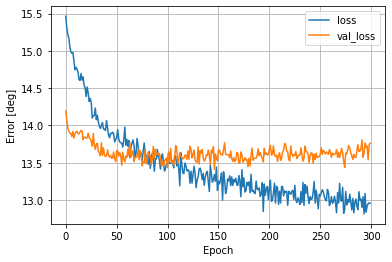

In [110]:
plt.figure()
plot_loss(history)

model.evaluate(x_test,  y_test, verbose=2)

y_pred_train = model.predict(x_train)
plt.figure(figsize = (20,6))
plt.plot(y_pred_train[:,-1])
plt.plot(y_train)

y_pred_test = model.predict(x_test)
plt.figure(figsize = (20,6))
plt.plot(y_pred_test[:,-1])
plt.plot(y_test)

### Notes on V2
V2 approach used a smaller depth pixels (24 x 32) than original (120 x 160). Didn't work well. Still have issues with over fitting. Maybe we should collect more training data, since the training data I have is only 4664. The MNIST had training data of 60,000. I'll try collecting more data for 10 minutes. 

## Create Neural Network V3

In [165]:
n_test = 18
date = '11_11_2020'
test_str = r'\test' + str(n_test)
data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str

train_dcamera_path = data_dir + r'\depth_processed_leo_test'+str(n_test)+'.avi'
show_video = 0
x_temp = read_depth_camera(train_dcamera_path, show_video) / 255.0
N = x_temp.shape[0]
x_tempp = x_temp[0:N-518,:,:]
x_train = np.concatenate((x_train,x_tempp))


n_test =18
date = '11_11_2020'
test_str = r'\test' + str(n_test)
data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
qtm_file_data_dir = data_dir + r'\qtm_processed_leo_test' + str(n_test) + '_' + date + '.txt'
show_qtm_plot = True
theta_interest = 'z'
y_train_temp = read_output_data(qtm_file_data_dir,theta_interest)
y_train = np.concatenate((y_train, y_train_temp))


In [169]:
print(x_train.shape)
print(y_train.shape)
# a = x_tempp
# print(a.shape)
# print(y_train_temp.shape)
# print(a.shape[0] - y_train_temp.shape[0])

(17351, 24, 32)
(17351, 1)


In [192]:

n_neurons = 300 
model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(24, 32)),
        tf.keras.layers.Dense(n_neurons, activation='relu'),
        tf.keras.layers.Dense(n_neurons, activation='relu'),
        tf.keras.layers.Dense(n_neurons, activation='relu'),
        tf.keras.layers.Dense(n_neurons, activation='relu'),
        tf.keras.layers.Dense(n_neurons, activation='relu'),
        tf.keras.layers.Dense(n_neurons, activation='relu'),
        tf.keras.layers.Dense(n_neurons, activation='relu'),
        tf.keras.layers.Dense(n_neurons, activation='relu'),
        tf.keras.layers.Dense(n_neurons, activation='relu'),
        tf.keras.layers.Dense(n_neurons, activation='relu'),
        tf.keras.layers.Dense(n_neurons, activation='relu'),
        tf.keras.layers.Dense(1)
])
    
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# loss_fn(y_train[:1], predictions).numpy()

model.compile(optimizer='adam',
              loss='mae',
              metrics=['mae'])

history = model.fit(x_train, y_train, epochs= 50, validation_split = 0.2)


Epoch 1/50
434/434 [==============================] - 2s 4ms/step - loss: 13.0706 - mae: 13.0706 - val_loss: 9.1149 - val_mae: 9.1149
Epoch 2/50
434/434 [==============================] - 1s 3ms/step - loss: 12.6893 - mae: 12.6893 - val_loss: 9.2450 - val_mae: 9.2450
Epoch 3/50
434/434 [==============================] - 1s 3ms/step - loss: 12.4491 - mae: 12.4491 - val_loss: 10.2224 - val_mae: 10.2224
Epoch 4/50
434/434 [==============================] - 1s 3ms/step - loss: 12.2987 - mae: 12.2987 - val_loss: 10.0432 - val_mae: 10.0432
Epoch 5/50
434/434 [==============================] - 1s 3ms/step - loss: 12.2364 - mae: 12.2364 - val_loss: 9.7913 - val_mae: 9.7913
Epoch 6/50
434/434 [==============================] - 2s 3ms/step - loss: 12.1073 - mae: 12.1073 - val_loss: 9.2694 - val_mae: 9.2694
Epoch 7/50
434/434 [==============================] - 2s 4ms/step - loss: 11.9696 - mae: 11.9696 - val_loss: 9.6075 - val_mae: 9.6075
Epoch 8/50
434/434 [==============================] - 1s 3

In [194]:
plt.figure()
plot_loss(history)
%matplotlib qt 

model.evaluate(x_test,  y_test, verbose=2)

y_pred_train = model.predict(x_train)
plt.figure(figsize = (20,6))
plt.plot(y_pred_train[:,-1])
plt.plot(y_train)

y_pred_test = model.predict(x_test)
plt.figure(figsize = (20,6))
plt.plot(y_pred_test[:,-1])
plt.plot(y_test)

55/55 - 0s - loss: 17.8444 - mae: 17.8444


## Notes on V3 
I tried with more training data. No good results. The MAE is pretty large even during training. This means there is underfitting. I need more layers or nodes. I removed the regularization and dropouts to solve underfitting.  I realized there was a sync problem when the test trials are long. Need to debug this issue before collecting more data. Things to try: higher sampling rate (60Hz) for more data frames, twisting at same leaning angle. 